<a href="https://colab.research.google.com/github/andreasfloros/ARM-ML-Embedded/blob/main/bharat1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download dataset:

In [1]:
import os
import requests
import tarfile

ROOT = 'audio_data/'
os.mkdir(ROOT)
url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
target_path = ROOT + 'dataset.tar.gz'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

tar = tarfile.open(target_path, "r:gz")
tar.extractall(path=ROOT)
tar.close()

Organise data + preprocessing:

In [3]:
import json
import os
import math
import librosa

JSON_PATH = ROOT + "data.json"
SAMPLE_RATE = 16000
WAV_DURATION = 1 # measured in seconds
SAMPLES_PER_WAV = SAMPLE_RATE * WAV_DURATION
num_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 1

data = {
    'mapping' : [],
    'labels' : [],
    'mfcc' : []
}

samples_per_segment = int(SAMPLES_PER_WAV / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(ROOT)):
    if dirpath is not ROOT:
        if i == 4: # will only look at two 3 words for now
          break
        semantic_label = dirpath.split("/")[-1]
        data["mapping"].append(semantic_label)
        print("\nProcessing: {}".format(semantic_label))
        for f in filenames:
          if f[-4:] != '.wav':
            pass
          else:
              file_path = os.path.join(dirpath, f)
              signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
              if len(signal) != SAMPLES_PER_WAV:
                print('Found wav with duration neq to 1s')

              # dsp processing goes here
              for d in range(num_segments):

                  # calculate start and finish sample for current segment
                  start = samples_per_segment * d
                  finish = start + samples_per_segment

                  # extract mfcc
                  mfcc = librosa.feature.mfcc(signal[start:finish], SAMPLE_RATE, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                  mfcc = mfcc.T

                  # store only mfcc feature with expected number of vectors
                  if len(mfcc) == num_mfcc_vectors_per_segment:
                      data["mfcc"].append(mfcc.tolist())
                      data["labels"].append(i-1)

# save MFCCs to json file
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)

Streaming output truncated to the last 5000 lines.
audio_data/sheila/fffcabd1_nohash_1.wav, segment:1
audio_data/sheila/8d8d9855_nohash_1.wav, segment:1
audio_data/sheila/7c75a504_nohash_0.wav, segment:1
audio_data/sheila/de41f895_nohash_3.wav, segment:1
audio_data/sheila/61abbf52_nohash_0.wav, segment:1
audio_data/sheila/6301e683_nohash_0.wav, segment:1
audio_data/sheila/ec545975_nohash_0.wav, segment:1
audio_data/sheila/ce0cb033_nohash_0.wav, segment:1
audio_data/sheila/ac899eb7_nohash_0.wav, segment:1
audio_data/sheila/f192e6b4_nohash_1.wav, segment:1
audio_data/sheila/f2dd248e_nohash_3.wav, segment:1
audio_data/sheila/2903efb3_nohash_0.wav, segment:1
audio_data/sheila/28ed6bc9_nohash_0.wav, segment:1
audio_data/sheila/4f2be90f_nohash_0.wav, segment:1
Found wav with duration neq to 1s
Found wav with duration neq to 1s
audio_data/sheila/5fc3ed24_nohash_0.wav, segment:1
audio_data/sheila/6982fc2a_nohash_0.wav, segment:1
Found wav with duration neq to 1s
audio_data/sheila/3006c271_noha

['three', 'sheila', 'off']
(5150, 32, 13)
(5150, 32, 13, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 11, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 6, 32)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 6, 32)         128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 2, 64)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 2, 64)          256       
____________________________________________________________

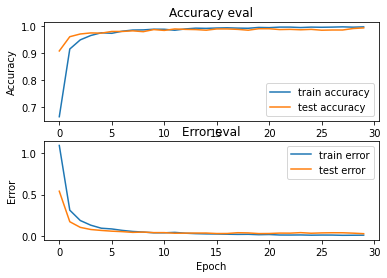

In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)
    print(data["mapping"])
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(X_train.shape)
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...]

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))




# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)



In [9]:
model.save("model1.h5")

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)


68/68 - 0s - loss: 0.0516 - accuracy: 0.9856

Test accuracy: 0.9855545163154602
Target: 0, Predicted label: [0]


In [11]:
import tensorflow as tf
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model1.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("model1.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmps946oe41/assets
Model is 315464 bytes


In [ ]:
# !echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
# !cat model1.tflite | xxd -i                                  >> /content/model.h
# !echo "};"                                                          >> /content/model.h

# import os
# model_h_size = os.path.getsize("model.h")
# print(f"Header file, model.h, is {model_h_size:,} bytes.")
# print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

In [12]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [13]:
with open("model1" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "model1"))